#  Analyzing time irreversibility through the lens of a neural network

## Nikolai Gruzinov$^1$, Andrey Ustyuzhanin$^2$

$^1$ Constructor University, Bremen, Germany

$^2$ National University of Singapore

## Abstract

Time irreversibility is a fundamental concept in physics, and the analysis of this property can provide insights into the underlying physical laws that govern the universe.
However, the study of time irreversibility is often limited to mathematical models and computational simulations, and it can be challenging to gain a deeper understanding of the underlying principles.
In this project, we aim to analyze time irreversibility through the lens of neural networks.
The approach would be to compare the performance of the predictive models in both time directions for various physical systems, including Kepler orbital motion, Lorenz attractors and Belousov-Zhabotinsky reaction.
The difference in performance or architecture giving similar performance should indicate the symmetry in the physics laws.

Predicting the trajectory of a dynamical system can be thought of as a time series problem: knowing the position at moments $t_{1}, \ldots, t_{n-1}$, predict the position at time $t_n$.
In this project we use primitive ML to test the following hypothesis: if the process is irreversible, time reversal of the trajectory should affect the difficulty of such prediction.

## Method in a nutshell

![](README_method.png)

1. Generate time series data (see e.g. `generate_time_series.py`).
2. Chop it into sliding windows.
3. Train a model to predict a point after and before the window, given the window.
4. Compare performance / prediction quality.
5. Different performance forward and backward => irreversibility.

Physical and other processes under consideration:
- Brownian particle from the paper in [Nature](https://www.nature.com/articles/s41567-020-1018-2) (`brownian_datagen.py`), the stochastic thermodynamic system
- probabilistic time series from the papers by Maximilano Zanin (`zanins_time_series.ipynb`),
- damped harmonic oscillator, damped double pendulum
- Lorenz attractor, Belousov-Zhabotinsky reaction, Kepler motion

## The remaining part of this notebook demonstrates our approach using the *damped harmonic oscillator* dataset.

### More experiments are available in the main repo. Scroll down for Conclusions.

In [18]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from typing import Dict, List

In [1]:
from train_test_utils import LossDistribution
from generate_time_series import load_harmonic_oscillator_time_series, plot_data_componentwise

In [3]:
def all_plots_for_datafile(filepath: str) -> None:
    l = LossDistribution(filepath)
    l.plot_relmeandiff_vs_epoch()

In [4]:
def compile_loss_distributions() -> List[LossDistribution]:
    def get_friction_coef(path: str) -> float:
        x = re.search("friction=(0.[0-9]+)", path)
        if x is None:
            raise ValueError(f"path {path} doesn't have friction in it")
            
        return float(x.groups()[0])
        
    root, _, files = next(os.walk("20230507_distributions/"))
    files = [os.path.join(root, f) for f in files if "damped_harmonic_oscillator_friction" in f]
    loss_distributions = [LossDistribution(path) for path in files]
    for l in loss_distributions:
        l.friction = get_friction_coef(l.filepath)
        
    loss_distributions = sorted(loss_distributions, key=lambda l: l.friction)
    return loss_distributions

loss_distributions = compile_loss_distributions()
print(len(loss_distributions))
loss_distributions[0].friction

8


0.0

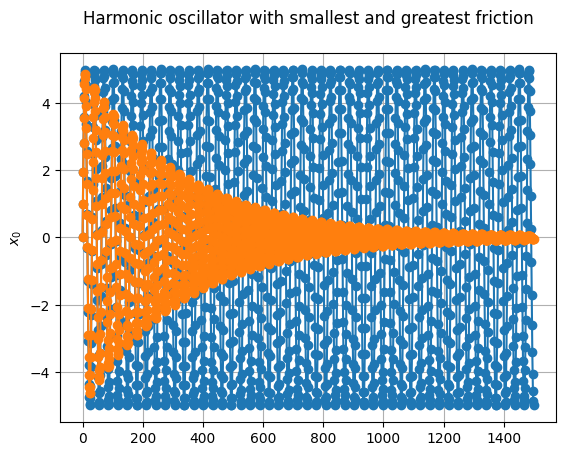

In [5]:
# %matplotlib qt5
plot_data_componentwise(load_harmonic_oscillator_time_series(friction=0., t_duration=300),
                        load_harmonic_oscillator_time_series(friction=0.03, t_duration=300),
                        title="Harmonic oscillator with smallest and greatest friction\n")

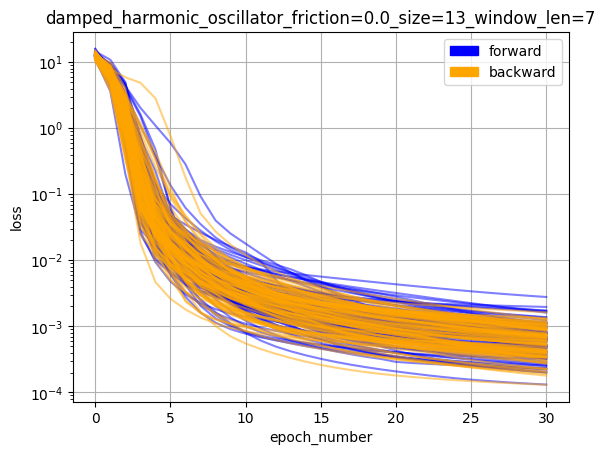

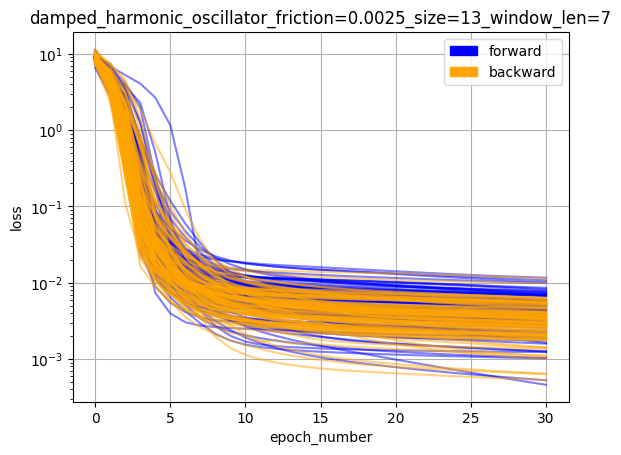

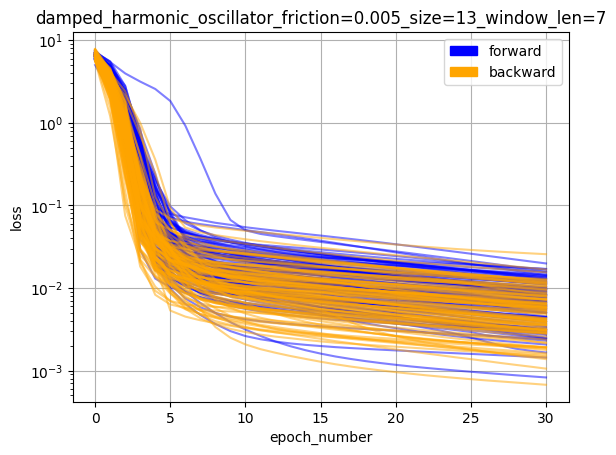

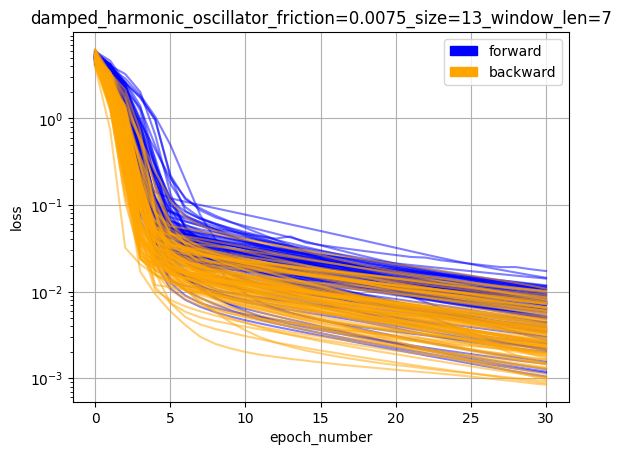

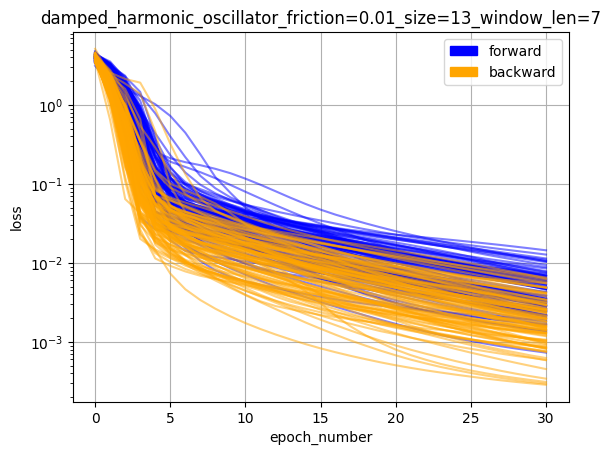

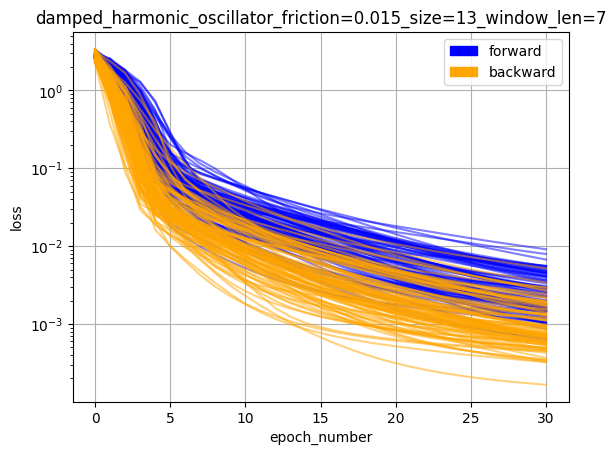

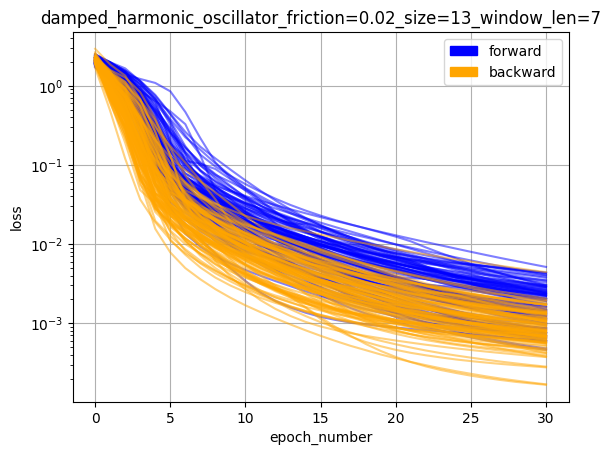

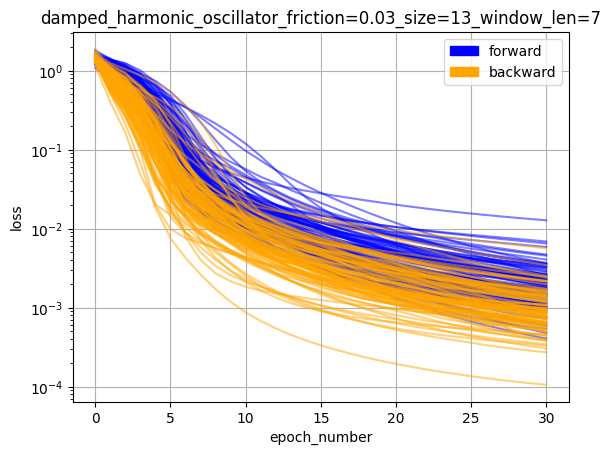

In [6]:
for l in loss_distributions:
    # print(f"friction: {l.friction}")
    l.plot_learning_curves()
    #l.plot_relmeandiff_vs_epoch()

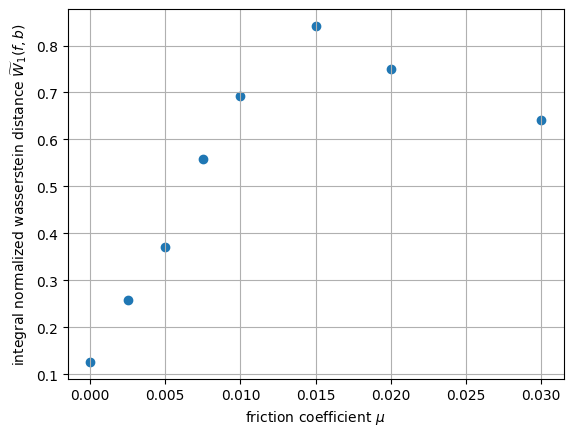

In [11]:
def plot_integral_wasserstein_vs_friction(loss_distributions) -> None:
    frictions = [l.friction for l in loss_distributions]
    
    integral_wassersteins = [np.mean(l.normalized_wasserstein_all()) for l in loss_distributions]
    plt.scatter(frictions, integral_wassersteins)
    plt.grid()
    plt.xlabel("friction coefficient $\\mu$")
    plt.ylabel("integral normalized wasserstein distance $\\widetilde{W}_1(f,b)$")
    plt.show()
    
plot_integral_wasserstein_vs_friction(loss_distributions)

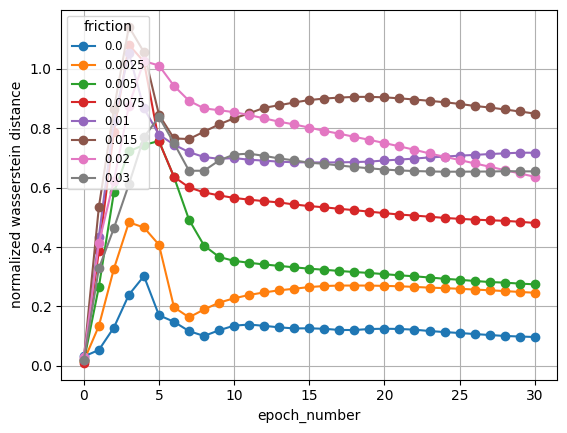

In [17]:
def plot_normalized_wasserstein_vs_epoch(loss_distributions) -> None:
    colors = pl.jet()
    for l in loss_distributions:
        plt.plot(l.normalized_wasserstein_all(), "o-", label=l.friction)
        
    plt.legend(title="friction", fontsize="small")
    plt.grid()
    plt.xlabel("epoch_number")
    plt.ylabel("normalized wasserstein distance")
    plt.show()
    
plot_normalized_wasserstein_vs_epoch(loss_distributions)

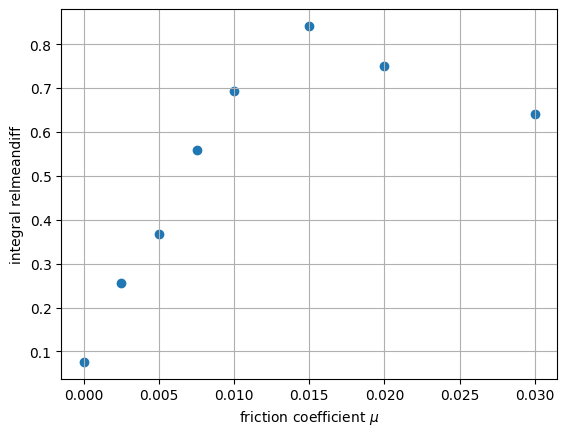

In [9]:
def plot_integral_relmindiff_vs_friction(loss_distributions) -> None:
    frictions = [l.friction for l in loss_distributions]
    def integral_relmindiff(l: LossDistribution) -> float:
        return np.mean(np.abs(l.relmeandiff_all()))
    
    integral_relmindiffs = [integral_relmindiff(l) for l in loss_distributions]
    plt.scatter(frictions, integral_relmindiffs)
    plt.grid()
    plt.xlabel("friction coefficient $\\mu$")
    plt.ylabel("integral relmeandiff")
    plt.show()
    
plot_integral_relmindiff_vs_friction(loss_distributions)

## Conclusion

We suggested a novel data-driven reversibility test and applied it to several synthetic datasets.
Kepler problem and double pendulum were found to be pefectly reversible, as expected.
Lorenz attractor and Belousov-Zhabotinsky reaction exhibited significant irreversibility.
We have shown that depending on the dataset and physical system in question, forward prediction might be more difficult than backward, and vice versa, and that irreversibility can manifest itself both ways.
We also demonstrated that chaos or periodicity in system's dynamics do not directly imply reported reversibility or irreversibility according to our method.
Our method could detect the time asymmetry due to friction and correctly identify the monotonous increase in irreversibility for small increasing values of the friction coefficient $\mu$.
However, for large values of $\mu$, the monotonous relation between the reported degree reversibility and friction coefficient did not hold.